In [13]:
import numpy as np
import imageio
import os
import argparse
import matplotlib.pyplot as plt
import sys

import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

In [2]:
sys.path.append('/tmp/pycharm_project_262/')
import model.vae2 as vae
import model.data_loader as data_loader
import utils

In [4]:
base_dir = '/scratch/image_datasets/3_65x65/ready/weights'
weights_path = os.path.join(base_dir, 'vae_20201211_151545/best.pth.tar')

model_vae = vae.BetaVAE(128)
model_vae.load_state_dict(torch.load(weights_path)['state_dict'])
model_vae.eval()

model_vae = model_vae.cuda()

In [5]:
json_path = os.path.join('/tmp/pycharm_project_262/', 'model', 'params.json')
params = utils.Params(json_path)
params.cuda = torch.cuda.is_available()  # use GPU if available
dataloaders = data_loader.fetch_dataloader(['test'], '/scratch/image_datasets/3_65x65/ready', params)
test_dl = dataloaders['test']

In [6]:
for data_batch in test_dl:

    # move to GPU if available
    data_batch = data_batch.cuda(non_blocking=True)
    # fetch the next evaluation batch
    data_batch = Variable(data_batch)

    # compute model output
    encodings, _, _ = model_vae.encode(data_batch)


In [7]:
encodings = encodings.detach().cpu().numpy()

In [8]:
np.min(encodings)

-3.3291934

In [9]:
encodings[0]

array([-4.04874355e-01, -4.71714810e-02,  1.03075898e+00, -2.40795329e-01,
        1.20140485e-01, -8.13469529e-01, -6.44869506e-01, -8.68164241e-01,
        5.78785419e-01,  2.19005823e+00, -1.82745367e-01,  7.28188515e-01,
       -2.70004964e+00,  1.47726297e-01,  4.31561857e-01, -3.81249845e-01,
        1.38332999e+00, -5.47505498e-01,  8.11517835e-01,  2.47116804e-01,
        3.13582942e-02, -1.33907235e+00,  9.78638470e-01,  5.63702464e-01,
       -1.36166108e+00, -8.73600304e-01, -4.70336288e-01, -1.71052933e+00,
        3.82346421e-01, -4.01076376e-02, -6.01031423e-01, -1.08540423e-01,
       -2.63363779e-01, -1.43486309e+00, -6.81756020e-01, -8.34467530e-01,
       -4.95619744e-01,  7.99460709e-01,  2.32774615e+00,  5.51418185e-01,
       -1.42778957e+00,  1.21354342e+00,  2.45356590e-01, -1.98243797e-01,
        1.84711301e+00, -9.47164237e-01, -1.01505435e+00,  7.33042121e-01,
       -2.64143795e-01,  2.09842175e-02,  9.90704656e-01,  1.69562593e-01,
        3.64892155e-01, -

In [10]:
data_batch = data_batch.detach().cpu().numpy()

In [11]:
print(np.max(data_batch))

1.0


In [22]:
import PIL
image = imageio.imread('/home/niaki/Downloads/Lenna.png')
image = PIL.Image.open('/home/niaki/Downloads/Lenna.png')

In [14]:
eval_transformer = transforms.Compose([
    transforms.CenterCrop(64),
    transforms.ToTensor()])

In [20]:
type(eval_transformer)

torchvision.transforms.transforms.Compose

In [24]:
image = eval_transformer(image)

In [25]:
image.shape

torch.Size([3, 64, 64])

In [ ]:
def calculate_SSDs_for_descr(which_desc, image, patch_size=65, query_stride=65, compare_stride=65, nr_similar_patches=6, eps=0.0001):

    image_height = image.shape[0]
    image_width = image.shape[1]
    
    query_x_coords = []
    query_y_coords = []

    results_noisy_descr_patches_diffs = {}
    results_noisy_descr_patches_x_coords = {}
    results_noisy_descr_patches_y_coords = {}
    results_noisy_descr_patches_positions = {}

    counter_query_patches = 0

    # just for the sake of output
    total_nr_query_patches = len(range(0, image_width - patch_size + 1, query_stride)) * len(
        range(0, image_height - patch_size + 1, query_stride))

    for y_query in range(0, image_width - patch_size + 1, query_stride):
        for x_query in range(0, image_height - patch_size + 1, query_stride):
            sys.stdout.write("\r" + str(counter_query_patches + 1) + "/" + str(total_nr_query_patches))

            query_x_coords.append(x_query)
            query_y_coords.append(y_query)

            query_patch = image[x_query: x_query + patch_size, y_query: y_query + patch_size]
            
            if which_desc == 0:
#                 query_patch_descr = compute_descriptor(ae32_encoder, query_patch)
                pass
            elif which_desc == 1:
#                 query_patch_descr = compute_descriptor(vae.encoder, query_patch)
            
            else:
                raise Exception("Wrong input for which_desc")
            
            counter_compare_patches = 0

            patches_diffs = [1000000000]
            patches_x_coords = [-1]
            patches_y_coords = [-1]
            patches_positions = [-1]

            for y_compare in range(0, image_width - patch_size + 1, compare_stride):
                for x_compare in range(0, image_height - patch_size + 1, compare_stride):

                    compare_patch = image[x_compare: x_compare + patch_size, y_compare: y_compare + patch_size]

                    if which_desc == 0:
#                         compare_patch_descr = compute_descriptor(ae32_encoder, compare_patch)
                        pass
                    elif which_desc == 1:
#                         compare_patch_descr = compute_descriptor(vae.encoder, compare_patch)
            
                    else:
                        raise Exception("Wrong input for which_desc")

                    diff = calculate_ssd(query_patch_descr, compare_patch_descr)

                    if diff < eps:
                        counter_compare_patches += 1
                        continue

                    # sorting
                    for i in range(len(patches_diffs)):
                        if diff < patches_diffs[i]:
                            patches_diffs.insert(i, diff)
                            patches_x_coords.insert(i, x_compare)
                            patches_y_coords.insert(i, y_compare)
                            patches_positions.insert(i, counter_compare_patches)
                            break

                    counter_compare_patches += 1
            
                       
            results_noisy_descr_patches_diffs[counter_query_patches] = patches_diffs[:nr_similar_patches]
            results_noisy_descr_patches_x_coords[counter_query_patches] = patches_x_coords[:nr_similar_patches]
            results_noisy_descr_patches_y_coords[counter_query_patches] = patches_y_coords[:nr_similar_patches]
            results_noisy_descr_patches_positions[counter_query_patches] = patches_positions[:nr_similar_patches]

            counter_query_patches += 1

    ssds = []
    ssims = []
    psnrs=[]

    for q_it in range(total_nr_query_patches):
        for c_it in range(nr_similar_patches):

            # getting the query patch from the clean image
            x_query = query_x_coords[q_it]
            y_query = query_y_coords[q_it]
            query_patch = image[x_query: x_query + patch_size, y_query: y_query + patch_size]

            # getting the compare patch from the clean image
            x_compare = results_noisy_descr_patches_x_coords[q_it][c_it]
            y_compare = results_noisy_descr_patches_y_coords[q_it][c_it]
            compare_patch = image[x_compare: x_compare + patch_size, y_compare: y_compare + patch_size]

            # calculating the difference in the clean image
            actual_diff = calculate_ssd(query_patch, compare_patch)
            ssds.append(actual_diff)
            
            dr_max = max(query_patch.max(), compare_patch.max())
            dr_min = min(query_patch.min(), compare_patch.min())
            diff_ssim = ssim(query_patch, compare_patch, data_range=dr_max - dr_min)
            ssims.append(diff_ssim)
            
            diff_psnr = calculate_psnr(query_patch, compare_patch, max_value=255)
            psnrs.append(diff_psnr)
            
    ssds = np.array(ssds)
    ssims = np.array(ssims)
    psnrs = np.array(psnrs)
    
    return ssds, ssims, psnrs

In [49]:
x_ax = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
retrieval_ssim = [0.2456442946, 0.2522387713, 0.2373298755, 0.2212246955, 0.209240617, 0.1603289464, 0.1621682582, 0.1590089617]
retrieval_psnr = [25.42065018, 24.5505158, 19.98648621, 15.80595361, 14.74284083, 13.93896855, 14.15154281, 13.57112419]

In [51]:
inversion_ssim = [0.4931766805, 0.5089288117, 0.4895139822, 0.4059314291, 0.2677550599, 0.2018798471, 0.1781645129, 0.173142699]
inversion_psnr = [19.77837203, 20.24035882, 19.78922854, 18.11084078, 15.42325332, 12.80464801, 10.21999193, 9.132503846]

In [87]:
fig_size = (5, 2.5)
fig_size_combined = (5, 5)

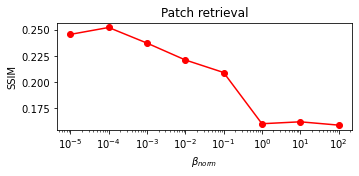

In [82]:
plt.figure(figsize=fig_size)
plt.title('Patch retrieval')
plt.plot(x_ax, retrieval_ssim, 'o-r')
plt.xlabel(r'$\beta_{norm}$')
plt.ylabel('SSIM')
plt.tight_layout()
axes = plt.gca()
axes.set_xscale('log')
plt.savefig("/home/niaki/Downloads/bVAE_patch_retrieval_ssim.pdf", bbox_inches='tight')

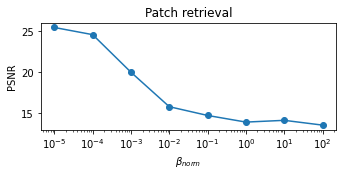

In [83]:
plt.figure(figsize=fig_size)
plt.title('Patch retrieval')
plt.plot(x_ax, retrieval_psnr, 'o-')
plt.xlabel(r'$\beta_{norm}$')
plt.ylabel('PSNR')
plt.tight_layout()
axes = plt.gca()
axes.set_xscale('log')
plt.savefig("/home/niaki/Downloads/bVAE_patch_retrieval_psnr.pdf", bbox_inches='tight')

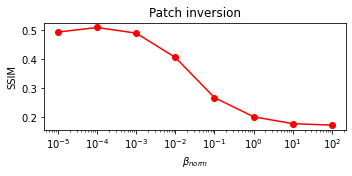

In [84]:
plt.figure(figsize=fig_size)
plt.title('Patch inversion')
plt.plot(x_ax, inversion_ssim, 'o-r')
plt.xlabel(r'$\beta_{norm}$')
plt.ylabel('SSIM')
plt.tight_layout()
axes = plt.gca()
axes.set_xscale('log')
plt.savefig("/home/niaki/Downloads/bVAE_patch_inversion_ssim.pdf", bbox_inches='tight')

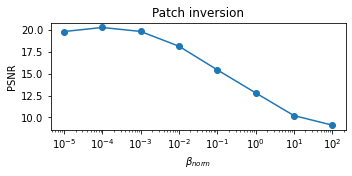

In [85]:
plt.figure(figsize=fig_size)
plt.title('Patch inversion')
plt.plot(x_ax, inversion_psnr, 'o-')
plt.xlabel(r'$\beta_{norm}$')
plt.ylabel('PSNR')
plt.tight_layout()
axes = plt.gca()
axes.set_xscale('log')
plt.savefig("/home/niaki/Downloads/bVAE_patch_inversion_psnr.pdf", bbox_inches='tight')

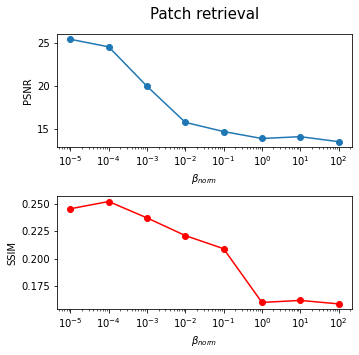

In [97]:
plt.figure(figsize=fig_size_combined)
plt.subplot(2,1,1)
plt.title('Patch retrieval', y=1.08, fontsize=15)
plt.plot(x_ax, retrieval_psnr, 'o-')
plt.xlabel(r'$\beta_{norm}$')
plt.ylabel('PSNR')
plt.tight_layout()
axes = plt.gca()
axes.set_xscale('log')
plt.subplot(2,1,2)
plt.plot(x_ax, retrieval_ssim, 'o-r')
plt.xlabel(r'$\beta_{norm}$')
plt.ylabel('SSIM')
plt.tight_layout()
axes = plt.gca()
axes.set_xscale('log')

plt.savefig("/home/niaki/Downloads/bVAE_patch_retrieval.pdf", bbox_inches='tight')

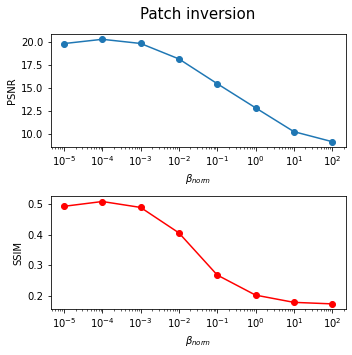

In [99]:
plt.figure(figsize=fig_size_combined)
plt.subplot(2,1,1)
plt.title('Patch inversion', y=1.08, fontsize=15)
plt.plot(x_ax, inversion_psnr, 'o-')
plt.xlabel(r'$\beta_{norm}$')
plt.ylabel('PSNR')
plt.tight_layout()
axes = plt.gca()
axes.set_xscale('log')
plt.subplot(2,1,2)
plt.plot(x_ax, inversion_ssim, 'o-r')
plt.xlabel(r'$\beta_{norm}$')
plt.ylabel('SSIM')
plt.tight_layout()
axes = plt.gca()
axes.set_xscale('log')

plt.savefig("/home/niaki/Downloads/bVAE_patch_inversion.pdf", bbox_inches='tight')